In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pickle
from tensorflow.models.rnn import rnn, rnn_cell

In [2]:
pwd

u'/Users/abhimanyu/GitHub/Project_cs224D/mnist(Projectcode&poster)'

In [3]:
embedding=np.loadtxt('../../Project_cs224D/w2v_data1Bmedline/embedding_matrix')
with open('../../Project_cs224D/w2v_data1Bmedline/dictionary.pickle','rb') as handle:
    dictionary=pickle.load(handle)
with open('../../Project_cs224D/w2v_data1Bmedline/reverse_dictionary.pickle','rb') as handle:
    reverse_dictionary=pickle.load(handle)    


In [4]:
print len(embedding)

245214


In [5]:
with open('../Relations/relations_label_dict_new.pickle','rb') as handle:
    relations=pickle.load(handle)

In [6]:
sentences, labels = zip(*[(key, value) for (key, value) in relations.iteritems()])

In [7]:
mapping={-1:(0,1),1:(1,0)}
labels=[mapping[label] for label in labels]


In [8]:
a=np.arange(10)
print a[:4]
print a[4:]

[0 1 2 3]
[4 5 6 7 8 9]


In [9]:
#DEFINING THE TRAINING AND TESTING DATA HERE


train_sentences=sentences[:1600]
test_sentences=sentences[1600:1900]
dev_sentences=sentences[1900:]
train_labels=labels[:1600]
test_labels=labels[1600:1900]
dev_labels=labels[1900:]
#print len(train_sentences)

In [10]:
lengths_sents=[len(sent) for sent in sentences]
print np.sum(lengths_sents)
print len(lengths_sents)
print np.sum(lengths_sents)/len(lengths_sents)


81438
2157
37


In [11]:
###ADDED THE PAD symbol to the embedding at the end. IT is all zeros
###The dictionary is updated as well

embedding=np.vstack([embedding,np.zeros(128)])
dictionary['PAD']=len(embedding)-1
reverse_dictionary[len(embedding)-1]='PAD'
dictionary['PAD']

245214

In [12]:
print embedding[-1]
print len(embedding)
print dictionary['PAD']

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.]
245215
245214


In [13]:
#Processes a sentence to a fixed lenght of 38. This is the mean lenght of a sentence in my training data
#Returns a padded sentence of the one we input
def process_sentence(sentence,length=38):
    length_sent=len(sentence)
    if length_sent<length:
        return_sent=[]
        for i in range(length):
            return_sent.append('PAD')
        return_sent[:length_sent]=sentence
    else:
        return_sent=sentence[:length]
    
    
    return return_sent


    
sent=['rea','re']
process_sentence(sent)
    

['rea',
 're',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD']

In [14]:
def get_indexes(padded_sent):
    return_index=[]
    for word in padded_sent:
        if word in dictionary:
            return_index.append(dictionary[word])
        else:
            return_index.append(dictionary['UNK'])
    return return_index    

# sent=['rea','re','coolio']
# get_indexes(process_sentence(test_sentences[50]))

In [15]:
print len(train_sentences)

1600


In [16]:
# epoch/batch_size

In [17]:
# Parameters
learning_rate = 0.001
epoch=len(train_sentences)
training_iters = epoch*20

batch_size = 30
display_step = epoch/batch_size
# Network Parameters
n_input = 128 #size of each word vector
n_steps = 150 # timesteps in each sample. Average length of a word
n_hidden = 200 # hidden layer num of features
n_classes = 2 # total classes is 2 for positive or negative sample

In [18]:
# tf Graph input
#x = tf.placeholder("float", [None, n_steps, n_input])
x = tf.placeholder("float", [None, n_steps, n_input])   #Number of steps can be variable
istate = tf.placeholder("float", [None, 2*n_hidden]) #state & cell => 2x n_hidden
y = tf.placeholder("float", [None, n_classes])

# Define weights
weights = {
    'hidden': tf.Variable(tf.random_normal([n_input, n_hidden])), # Hidden layer weights
    'out': tf.Variable(tf.random_normal([n_hidden, n_classes]))
}
biases = {
    'hidden': tf.Variable(tf.random_normal([n_hidden])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

In [19]:
def RNN(_X, _istate, _weights, _biases):

    # input shape: (batch_size, n_steps, n_input)
    shape=_X.get_shape().as_list()  #Gets the shape of the tensor
    _X = tf.transpose(_X, [1, 0, 2])  # permute n_steps and batch_size
    
    # Reshape to prepare input to hidden activation
    _X = tf.reshape(_X, [-1, n_input]) # (n_steps*batch_size, n_input)
    # Linear activation
    _X = tf.matmul(_X, _weights['hidden']) + _biases['hidden']

    # Define a lstm cell with tensorflow
    lstm_cell = rnn_cell.BasicLSTMCell(n_hidden, forget_bias=0.9)
    # Split data because rnn cell needs a list of inputs for the RNN inner loop
    _X = tf.split(0, shape[1], _X) # n_steps * (batch_size, n_hidden)

    # Get lstm cell output
    outputs, states = rnn.rnn(lstm_cell, _X, initial_state=_istate)

    # Linear activation
    # Get inner loop last output
    return tf.matmul(outputs[-1], _weights['out']) + _biases['out']

In [20]:
pred = RNN(x, istate, weights, biases)

# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(pred, y)) # Softmax loss
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost) # Adam Optimizer

# Evaluate model
correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [21]:

# def get_next_batch(step):
#     total_sent=len(train_sentences)
#     sent=get_indexes(process_sentence(train_sentences[step%total_sent]))
#     x_data=embedding[sent]
#     y_data=train_labels[step%total_sent]
#     return x_data,np.array(y_data)
    
def next_batch(batch_size,epoch,index_in_epoch,train_sentences,train_labels):
    """Return the next `batch_size` examples from this data set."""
#     if fake_data:
#       fake_image = [1.0 for _ in xrange(784)]
#       fake_label = 0
#       return [fake_image for _ in xrange(batch_size)], [
#           fake_label for _ in xrange(batch_size)]
    start = index_in_epoch
    index_in_epoch += batch_size
    if index_in_epoch > len(train_sentences):
        # Finished epoch
        epoch += 1
        # Shuffle the data
        perm = numpy.arange(len(train_sentences))
        np.random.shuffle(perm)
        train_sentences=train_sentences[perm]
        train_labels=train_labels[perm]
        # Start next epoch
        start=0
        index_in_epoch = batch_size
        assert batch_size <= len(train_sentences)
        
      
      
      
      
      
      
      
      
      
    end = index_in_epoch
    sentences_batch=train_sentences[start:end]
    sentences_batch=[get_indexes(process_sentence(sent,n_steps)) for sent in sentences_batch]
    embed_sentence_batch=[embedding[sent] for sent in sentences_batch]
    return embed_sentence_batch,train_labels[start:end]    
    
        
        
        
        
    

epoch 0, Minibatch Loss= 9.999010, Training Accuracy= 0.56667
epoch 1, Minibatch Loss= 0.662406, Training Accuracy= 0.60000
epoch 2, Minibatch Loss= 0.660295, Training Accuracy= 0.60000
epoch 3, Minibatch Loss= 0.658951, Training Accuracy= 0.60000
epoch 4, Minibatch Loss= 0.658096, Training Accuracy= 0.60000
epoch 5, Minibatch Loss= 0.657524, Training Accuracy= 0.60000
epoch 6, Minibatch Loss= 0.657123, Training Accuracy= 0.60000
epoch 7, Minibatch Loss= 0.656828, Training Accuracy= 0.60000
epoch 8, Minibatch Loss= 0.656586, Training Accuracy= 0.60000
epoch 9, Minibatch Loss= 0.656216, Training Accuracy= 0.60000
epoch 10, Minibatch Loss= 0.656712, Training Accuracy= 0.60000
epoch 11, Minibatch Loss= 0.656286, Training Accuracy= 0.60000
epoch 12, Minibatch Loss= 0.656191, Training Accuracy= 0.60000
epoch 13, Minibatch Loss= 0.656114, Training Accuracy= 0.60000
epoch 14, Minibatch Loss= 0.656050, Training Accuracy= 0.60000
epoch 15, Minibatch Loss= 0.655996, Training Accuracy= 0.60000
ep

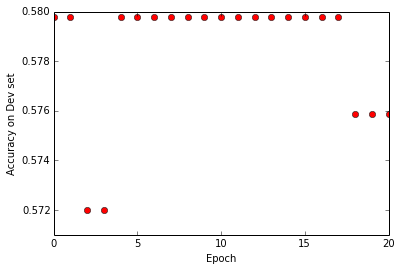

In [22]:
# Initializing the variables
init = tf.initialize_all_variables()
def get_dev_accuracy():
        
        dev_len = len(dev_sentences)
        dev_sentences_batch=[get_indexes(process_sentence(sent,n_steps)) for sent in dev_sentences]
        dev_embed_sentence_batch=[embedding[sent] for sent in dev_sentences_batch]
        dev_data = dev_embed_sentence_batch
        dev_label = dev_labels
        return sess.run(accuracy, feed_dict={x: dev_data, y: dev_label,
                                                                 istate: np.zeros((dev_len, 2*n_hidden))})


# Launch the graph
with tf.Session() as sess:
    sess.run(init)
    step = 0
    epoch=0
    index_in_epoch=0
    epoch_count=0
    # Keep training until reach max iterations
    epoch_list=[]
    dev_accuracy=[]
    while step * batch_size < training_iters:
        batch_xs, batch_ys = next_batch(batch_size,epoch,index_in_epoch,train_sentences,train_labels)
#         print np.shape (batch_xs)
#         break
        

        
        # Reshape data to get 28 seq of 28 elements
        #batch_xs = batch_xs.reshape((batch_size, n_steps, n_input))
#         batch_ys=batch_ys.reshape((batch_size,n_classes))
#         print np.shape(batch_xs)
#         print np.shape(batch_ys)
#         break
        # Fit training using batch data
        sess.run(optimizer, feed_dict={x: batch_xs, y: batch_ys,
                                       istate: np.zeros((batch_size, 2*n_hidden))})
        if step % display_step == 0:
            # Calculate batch accuracy
            acc = sess.run(accuracy, feed_dict={x: batch_xs, y: batch_ys,
                                                istate: np.zeros((batch_size, 2*n_hidden))})
            # Calculate batch loss
            loss = sess.run(cost, feed_dict={x: batch_xs, y: batch_ys,
                                             istate: np.zeros((batch_size, 2*n_hidden))})
            print "epoch " + str(epoch_count) + ", Minibatch Loss= " + "{:.6f}".format(loss) + \
                  ", Training Accuracy= " + "{:.5f}".format(acc)
            epoch_list.append(epoch_count)
            dev_accuracy.append(get_dev_accuracy())
            epoch_count+=1    
        step += 1
    print "Optimization Finished!"
    test_len = len(test_sentences)
    test_sentences_batch=[get_indexes(process_sentence(sent,n_steps)) for sent in test_sentences]
    test_embed_sentence_batch=[embedding[sent] for sent in test_sentences_batch]
    test_data = test_embed_sentence_batch
    test_label = test_labels
    print "Testing Accuracy:", sess.run(accuracy, feed_dict={x: test_data, y: test_label,
                                                             istate: np.zeros((test_len, 2*n_hidden))})
    print "Final Dev Accuracy", get_dev_accuracy()
    plt.plot(epoch_list,dev_accuracy,'ro')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy on Dev set')    
    plt.savefig('dev_accuracy_'+str(n_steps)+'.png')
    plt.show()

In [23]:
    # Calculate accuracy for 256 mnist test images
    

In [24]:
# a=tf.constant([[1,2,3],[3,4,5]])
# a.get_shape().as_list()[1].dtype

In [25]:
# sentences


In [26]:
a=np.ones(3)
b=np.zeros(3)
print np.vstack([a,b])

[[ 1.  1.  1.]
 [ 0.  0.  0.]]


In [27]:
a=[a,b]
a=np.reshape((2,3))

TypeError: reshape() takes at least 2 arguments (1 given)

In [ ]:
a=np.arange(10)
np.random.shuffle(a)
a

In [ ]:

import matplotlib.pyplot as plt

In [ ]:
# x=np.array([10, 20, 38, 50, 70, 85, 100])
# y=np.array([51.76, 55.0, 68, 63.8, 58.29,50.7,49.1])
# #import matplotlib.pyplot as plt

In [ ]:
# plt.plot(x,y,'ro')

# plt.savefig('plot.png')
# plt.show()

In [ ]:
def get_dev_accuracy():
        
        dev_len = len(dev_sentences)
        dev_sentences_batch=[get_indexes(process_sentence(sent,n_steps)) for sent in dev_sentences]
        dev_embed_sentence_batch=[embedding[sent] for sent in dev_sentences_batch]
        dev_data = dev_embed_sentence_batch
        dev_label = dev_labels
        return sess.run(accuracy, feed_dict={x: dev_data, y: dev_label,
                                                                 istate: np.zeros((dev_len, 2*n_hidden))})


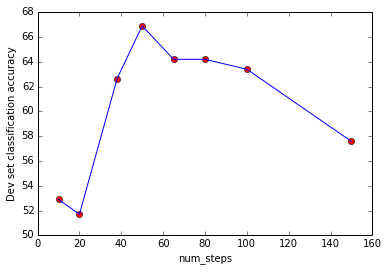

In [35]:
num_set=[10,20,38,50,65,80,100,150]
dev_set_accuracy=[52.9,51.7,62.64,66.9,64.2,64.2,63.4,57.58]

plt.plot(num_set,dev_set_accuracy,'ro')
plt.plot(num_set,dev_set_accuracy)

plt.xlabel('num_steps')
plt.ylabel('Dev set classification accuracy')
plt.savefig('classification_accuracy.png')
plt.show()




In [28]:
print len(sentences)

2157


In [29]:
print len(labels)

2157


In [34]:
count_plus=0
for label in labels:
    if label==(1,0):
        count_plus +=1
print count_plus, len(labels)-count_plus ,len(labels)       

906 1251 2157
